In [112]:
import numpy as np
import pandas as pd
import load_data as ld
import preprocess as pre
from numpy.linalg import norm
import networkx as nx
import operator
import dijkstra as d
from textrank import KeywordSummarizer


def cos_similarity(lst1, lst2):
    return np.dot(lst1, lst2)/(norm(lst1)*norm(lst2))

def rescale(num, maxNum):
    return maxNum*(1-num) + maxNum/10

def get_top_N(dict, n):
    sorted_dict = sorted(dict.items(), key=operator.itemgetter(1), reverse=True)[:n] #sorted(dict, key = dict.get, reverse=True)[:n]
    return sorted_dict

def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb
    
    
def get_nodes(title, option="TF", n=10):
    paragraphs = ld.read_txt(title + ".txt")
    if option=="TF":
        tokens_comb = pre.preprocess_node(paragraphs)
        dic_comb = pre.make_dic_count(tokens_comb)
        return get_top_N(dic_comb, n) 
    elif option=="textrank":
        keyword_extractor = KeywordSummarizer(
            tokenize = pre.mecab_tokenize,
            window = -1,
            verbose = False
        )
        dic_comb = []
        sents = " ".join(paragraphs).split(". ")
        keywords = keyword_extractor.summarize(sents, topk=n)
        for word, rank in keywords:
            dic_comb.append((word, rank))
        return dic_comb
            

def get_adj(title, nodes, option, scale):
    
    paragraphs = ld.read_txt(title + ".txt")
    tokens_paras, tokens_stcs = pre.preprocess_edge(paragraphs) 
    dic_paras = list(map(pre.make_dic_count, tokens_paras))
    dic_stcs = list(map(pre.get_stcs_dic, tokens_stcs))
    
    tokens_stcs = sum(tokens_stcs, [])
    dic_stcs = sum(dic_stcs, [])
    
    def get_vector(dictList, keyword):
        vector = []
        for dic in dictList:
            if keyword in dic.keys():
                vector.append(dic[keyword])
            else:
                vector.append(0)
        return vector
    
    N = len(nodes)
    cotable = np.ones((N, N)) * -1
        
    
    for i in range(N):
        for j in range(i+1, N):
            left, right = nodes[i][0], nodes[j][0]
            if option == "ss":
                for stc in tokens_stcs:
                    if left in stc and right in stc:
                        cotable[i][j] += 1        
            elif option == "ps":
                for para in tokens_paras:
                    if left in para and right in para:
                        cotable[i][j] += 1  
            elif option == "scs":
                Lvector = get_vector(dic_stcs, left)
                Rvector = get_vector(dic_stcs, right)
                cotable[i][j] = rescale(cos_similarity(Lvector, Rvector), scale)
            elif option == "pcs":
                Lvector = get_vector(dic_paras, left)
                Rvector = get_vector(dic_paras, right)
                cotable[i][j] = rescale(cos_similarity(Lvector, Rvector), scale)
            else:
                print("error : choose option among ('ss', 'ps', 'scs', 'pcs')")
                
    no_edge_idx = np.where(cotable == -1)
    
    if option == "ss" or "ps":
        maxvalue = np.max(cotable)
        cotable = rescale(cotable / maxvalue, scale)
        
    for i in range(len(no_edge_idx[0])):
        cotable[no_edge_idx[0][i], no_edge_idx[1][i]] = -1
    
    return cotable

def make_graph(nodes, adj):
    G = nx.Graph()
    for i in range(len(nodes)):
        for j in range(i+1, len(nodes)):
            if adj[i][j] != -1:
                nodei = str(nodes[i][0])+" "+str(nodes[i][1])
                nodej = str(nodes[j][0])+" "+str(nodes[j][1])
                G.add_edge(nodei, nodej, weight=adj[i][j])
    return G

def get_route(parent, start, end):
    route = []
    current = end
    while current != start:
        route.append(current)
        current = parent[current]
    
    route.append(start)
    route.reverse()
    return route 

def cutting_edge(graph, adj):

    nodes = list(graph.nodes)
    n = len(nodes)
    dist, parents = d.dijkstra(graph)
    newG = nx.Graph()
    id2name = {}
    for idx, name in enumerate(nodes):
        id2name[idx] = name

    for i in range(n):
        for j in range(i+1, n):
            if dist[i][j] != float('inf'):
                route = get_route(parents[i], i, j)
                for p in range(len(route)-1):
                    fromN = id2name[route[p]]
                    toN = id2name[route[p+1]]
                    if not newG.has_edge(fromN, toN):
                        newG.add_edge(fromN, toN, weight=adj[route[p]][route[p+1]])
    return newG

def percent_graph(graph, p, scale):
    newG = nx.Graph()
    for (u, v, w) in graph.edges(data=True):
        if w['weight'] <= scale*1.1*p and not newG.has_edge(u, v):
            newG.add_edge(u, v, weight=w['weight'])
    return newG

In [113]:
title = "녹차"
scale = 7
num_node = 10
option = "ss"
img_name = title + '_' + option + '_' + str(num_node)
nodes = get_nodes(title, "TF", num_node)
adj = get_adj(title, nodes, option, scale)
G = make_graph(nodes, adj)
cut_G = cutting_edge(G, adj)
percent_G = percent_graph(cut_G, 0.8, scale)

In [114]:
# 필요한 패키지와 라이브러리를 가져옴
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 그래프를 노트북 안에 그리기 위해 설정
%matplotlib inline

path = 'C:\\WINDOWS\\Fonts\\malgunbd.ttf'
font_name = fm.FontProperties(fname=path, size=10).get_name()
# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False
plt.rc('font', family=font_name)

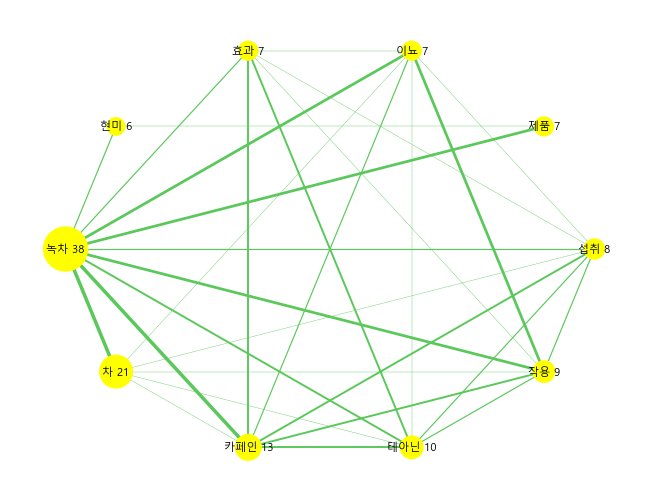

In [115]:
weights = nx.get_edge_attributes(G, "weight")
edges = G.edges()
nodeSize = [ int(t.split()[-1]) for t in list(G.nodes) ]
nodeSize = nodeSize / np.max(nodeSize) * 1000 

scaling_factor = 0.4 # to emphasise differences 
alphas = [(scale - weights[edge]) * scaling_factor for edge in edges]
colors = [rgb_to_hex((90, 200, 90)) for edge in edges]
#colors = [rgb_to_hex((int(75 * (weights[edge]/7))+180, int(140 * (1-weights[edge]/7))+70, 0  )) for edge in edges]
nx.draw_shell(G, edge_color=colors, node_color='yellow', node_size=nodeSize, font_size=8, width=alphas, with_labels=True, font_family=font_name)
#nx.draw_spring(G, edge_color=colors, node_color='yellow', node_size=nodeSize, font_size=8, width=alphas, with_labels=True, font_family=font_name)

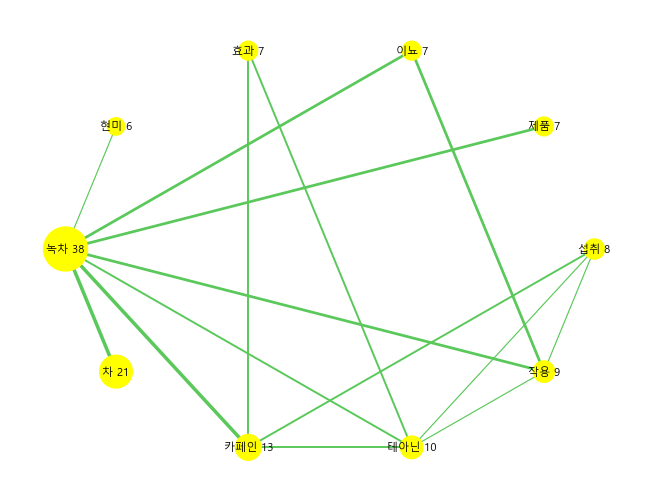

In [116]:
cut_G = cutting_edge(G, adj)
weights = nx.get_edge_attributes(cut_G, "weight")
edges = cut_G.edges()
nodeSize = [ int(t.split()[-1]) for t in list(cut_G.nodes) ]
nodeSize = nodeSize / np.max(nodeSize) * 1000 

scaling_factor = 0.4 # to emphasise differences 
alphas = [(scale - weights[edge]) * scaling_factor for edge in edges]
colors = [rgb_to_hex((90, 200, 90)) for edge in edges]
#colors = [rgb_to_hex((int(75 * (weights[edge]/7))+180, int(140 * (1-weights[edge]/7))+70, 0  )) for edge in edges]
nx.draw_shell(cut_G, edge_color=colors, node_color='yellow', node_size=nodeSize, font_size=8, width=alphas, with_labels=True, font_family=font_name)
#nx.draw_spring(cut_G, edge_color=colors, node_color='yellow', node_size=nodeSize, font_size=8, width=alphas, with_labels=True, font_family=font_name)

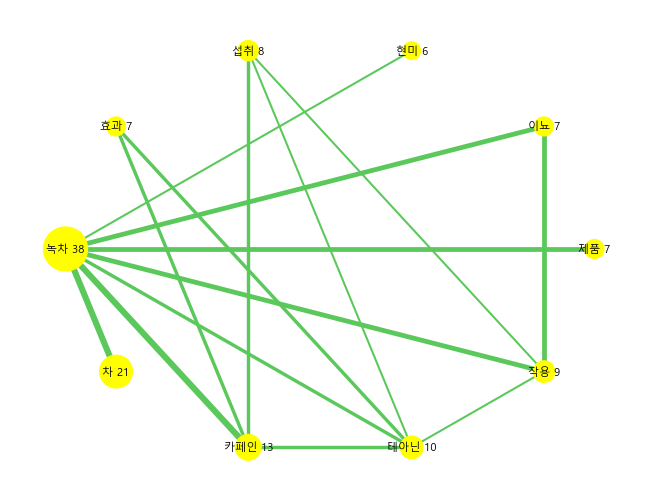

In [119]:
weights = nx.get_edge_attributes(percent_G, "weight")
edges = percent_G.edges()
nodeSize = [ int(t.split()[-1]) for t in list(percent_G.nodes) ]
nodeSize = nodeSize / np.max(nodeSize) * 1000 

scaling_factor = 0.7 # to emphasise differences 
alphas = [(scale - weights[edge]) * scaling_factor for edge in edges]
colors = [rgb_to_hex((90, 200, 90)) for edge in edges]
#colors = [rgb_to_hex((int(75 * (weights[edge]/7))+180, int(140 * (1-weights[edge]/7))+70, 0  )) for edge in edges]
nx.draw_shell(percent_G, edge_color=colors, node_color='yellow', node_size=nodeSize, font_size=8, width=alphas, with_labels=True, font_family=font_name)
#nx.draw_spring(percent_G, edge_color=colors, node_color='yellow', node_size=nodeSize, font_size=8, width=alphas, with_labels=True, font_family=font_name)

In [100]:
cut_G.degree

DegreeView({'녹차 38': 10, '차 21': 3, '카페인 13': 4, '테아닌 10': 6, '작용 9': 4, '섭취 8': 3, '제품 7': 1, '이뇨 7': 2, '효과 7': 2, '현미 6': 1, '홍차 5': 3, '색 5': 3, '중국 5': 3, '비타민 6': 1})

In [101]:
percent_G.degree

DegreeView({'녹차 38': 9, '차 21': 2, '카페인 13': 4, '테아닌 10': 6, '작용 9': 4, '제품 7': 1, '이뇨 7': 2, '현미 6': 1, '홍차 5': 3, '색 5': 2, '중국 5': 1, '섭취 8': 3, '효과 7': 2})

In [102]:
G.degree

DegreeView({'녹차 38': 12, '차 21': 10, '카페인 13': 8, '테아닌 10': 8, '작용 9': 7, '섭취 8': 7, '제품 7': 2, '이뇨 7': 7, '효과 7': 7, '현미 6': 2, '홍차 5': 6, '색 5': 4, '중국 5': 3, '비타민 6': 1})

In [8]:
G.edges

EdgeView([('녹차 38', '차 21'), ('녹차 38', '카페인 13'), ('녹차 38', '테아닌 10'), ('녹차 38', '작용 9'), ('녹차 38', '섭취 8'), ('녹차 38', '제품 7'), ('녹차 38', '이뇨 7'), ('녹차 38', '효과 7'), ('녹차 38', '현미 6'), ('차 21', '카페인 13'), ('차 21', '테아닌 10'), ('차 21', '작용 9'), ('차 21', '섭취 8'), ('차 21', '제품 7'), ('차 21', '이뇨 7'), ('차 21', '효과 7'), ('차 21', '현미 6'), ('카페인 13', '테아닌 10'), ('카페인 13', '작용 9'), ('카페인 13', '섭취 8'), ('카페인 13', '제품 7'), ('카페인 13', '이뇨 7'), ('카페인 13', '효과 7'), ('카페인 13', '현미 6'), ('테아닌 10', '작용 9'), ('테아닌 10', '섭취 8'), ('테아닌 10', '제품 7'), ('테아닌 10', '이뇨 7'), ('테아닌 10', '효과 7'), ('테아닌 10', '현미 6'), ('작용 9', '섭취 8'), ('작용 9', '제품 7'), ('작용 9', '이뇨 7'), ('작용 9', '효과 7'), ('작용 9', '현미 6'), ('섭취 8', '제품 7'), ('섭취 8', '이뇨 7'), ('섭취 8', '효과 7'), ('섭취 8', '현미 6'), ('제품 7', '이뇨 7'), ('제품 7', '효과 7'), ('제품 7', '현미 6'), ('이뇨 7', '효과 7'), ('이뇨 7', '현미 6'), ('효과 7', '현미 6')])